# Applied Data Visualization – Homework 2
*https://www.dataviscourse.net/2024-applied/*


In this homework we will further explore the avalanche data by creating custom charts in Matplotlib. 

**Note that you may only use Matplotlib for this homework; no other charting libraries like Seaborn!**

## Your Info and Submission Instructions

* *First name: Logan*
* *Last name: Correa*
* *Email: u1094034@umail.utah.edu*
* *UID: u1094034*



For your submission, please do the following things: 
* **rename the file to `hw2_lastname.pynb`**
* **include all files that you need to run the homework, including the data file provided** 
* **don't use absolute paths, but use a relative path to the same directory for referencing data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime


plt.style.use('default')
# This next line tells jupyter to render the images inline
%matplotlib inline
import matplotlib_inline
# This renders your figures as vector graphics AND gives you an option to download a PDF too
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

## Read & Clean up the Data

You've already done data cleanup in the previous homework, so we'll provide this for you. 

In [2]:
avy_df = pd.read_csv('./avalanches.csv')

# Clean dates and elevation
avy_df['Date'] = pd.to_datetime(avy_df['Date'])
avy_df['Year'] = avy_df['Date'].dt.year.astype('Int64')
avy_df['Month'] = avy_df['Date'].dt.month.astype('Int64')
avy_df['Elevation_Feet'] = pd.to_numeric(avy_df['Elevation'].str.replace('\'', '').str.replace(',', ''))

# Filter out null dates and incomplete years
avy_df = avy_df[avy_df['Date']==avy_df['Date']]
avy_df = avy_df[avy_df['Year'] > 2009]

# Part 1: Violin Plot Per Region

* Create a horizontal violin plot of distributions of avalanche elevations by Region.  
* Sort the regions by the median avalanche elevation in a descending order. 
* Plot the mean on the violing plot. 
* Create lables for the regions that also show the number of avalances in the region. For example: "Salt Lake (3654)"
* Analyze the data. What are trends you see? 

Hints: 
* you'll need to create a series of elevation values for each region 
* Matplotlib violinplots don't like NAN values, make sure to drop them before you try to plot

You can choose your own aesthetics, but make sure it looks good. 

For your reference, here is our solution: 

![Example](violinplot.svg)

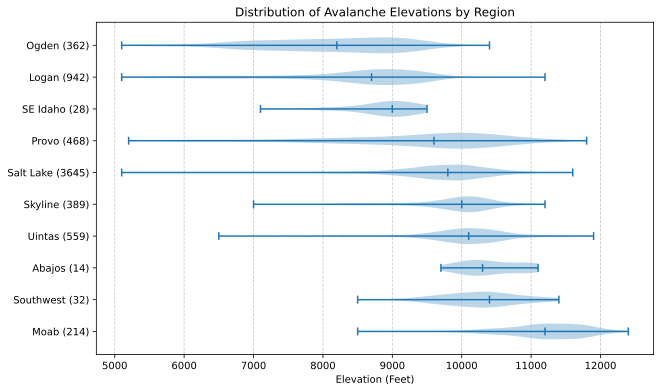

In [20]:
# Filter out Nan values
avy_filtered = avy_df.dropna(subset=['Elevation_Feet'])

# group by region sorted by median elevation
sorted_regions = avy_filtered.groupby('Region')['Elevation_Feet'].median().sort_values(ascending=False).index

# create list of elevation data for each region
elevation_data = [avy_filtered[avy_filtered['Region'] == region]['Elevation_Feet'] for region in sorted_regions]

# create labels for regions with number of avalances
region_labels = region_labels = [f"{region} ({len(avy_filtered[avy_filtered['Region'] == region])})" for region in sorted_regions]

# create horizontal violin plot
plt.figure(figsize=(10, 6))
violins = plt.violinplot(elevation_data, vert=False, showmedians=True)

# Labels and title
plt.yticks(range(1, len(region_labels) + 1), region_labels)
plt.xlabel('Elevation (Feet)')
plt.title('Distribution of Avalanche Elevations by Region')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.show()


### Your Analysis: 



# Part 2: Radial Bar Chart

* Create a radial bar chart of the average number of avalanches in a year by Aspect.
* Arrange the aspects in the usual convention (North at the top, West on the left, etc.).
* Color the barchart using a cyclic colormap (e.g., HSV).
* Provide an analysis.

Hints: 
* Here is some useful reading: [https://matplotlib.org/stable/api/projections/polar.html](https://matplotlib.org/stable/api/projections/polar.html)

Here is our solution: 

![A radial visualization of avalanches per aspect](radial.svg)

In [4]:
# your code here


### Your Analysis: 


# Part 3: Rolling average area subplots

* Create a chart where each subfigure is an area chart of the 7-day rolling average of the number of avalanches in a given ski season. Assume that a "ski season" starts July 1 and ends June 31.
* The subplots should overlap so that outliers are less of a problem.
* Provide an analysis of the data. 

Useful methods to consider: 
- Pandas's `.rolling()`
- matplotlib's `.fill_between()`, `.set_axis_off()`, `.tight_layout()`
- datetime's `.timetuple().tm_yday`

Make sure to check out the arguments of the above methods.

Here's how your result should look: 

![A series of line charts showing avalanches over time](line.svg)

In [5]:
# your code here


### Your Analysis: 
